# Estimating Fluxes at INST state

To estimate metabolic fluxes at the INST state, FreeFlux uses a nonlinear optimization approach that takes into account both metabolite concentrations and MDVs from multiple timepoints. The problem can be defined mathematically as follows:

![Optimization problem ><](images/inst_eqn.gif)

Here, ${\bf{x}}_{sim}$ represents the simulated MDVs at all timepoints, and ${\bf{v}}_{sim}$ represents the simulated fluxes. Both are functions of the independent variable vector $\bf{p}$, which includes free fluxes $\bf{u}$ and concentrations $\bf{c}$. ${\bf{x}}_{exp}$ and ${\bf{v}}_{exp}$ are the measurements of MDV and flux, respectively, and ${\bf{\Sigma }}_{{{\bf{x}}_{exp}}}^{ - 1}$ and ${\bf{\Sigma }}_{{{\bf{v}}_{exp}}}^{ - 1}$ are the inverses of the covariance matrix of measurements. $\bf{N}$ is the null space of stoichiometric matrix of the network reactions, and $\bf{T}$ denotes the matrix that transforms total fluxes to net fluxes.

## Solving both the Fluxes and Concentrations

Similar to before, we start by building a metabolic model by reading the reactions from a [file](https://github.com/Chaowu88/freeflux/tree/main/models/toy).

In [1]:
from freeflux import Model

MODEL_FILE = 'path/to/reactions.tsv'

model = Model('demo')
model.read_from_file(MODEL_FILE)

ifit = model.fitter('inst')

Next, we specify the labeling strategy for the labeled substrates:

In [2]:
ifit.set_labeling_strategy(
    'AcCoA', 
    labeling_pattern = ['01', '11'], 
    percentage = [0.25, 0.25], 
    purity = [1, 1]
)   # call this method for each labeled substrate

The measured metabolite-derived isotopomer fractions (MDVs) and fluxes can be loaded one by one using `set_measured_MDV` and `set_measured_flux`, or all at once from [files](https://github.com/Chaowu88/freeflux/tree/main/models/toy) using `set_measured_MDVs_from_file` and `set_measured_fluxes_from_file`:

In [3]:
MEASURED_MDV_FILE = 'path/to/measured_inst_MDVs.tsv'
MEASURED_FLUX_FILE = 'path/to/measured_fluxes.tsv'

ifit.set_measured_MDVs_from_file(MEASURED_MDV_FILE)
ifit.set_measured_fluxes_from_file(MEASURED_FLUX_FILE)

Next, we set the lower and upper bounds for the net fluxes and concentrations using `set_flux_bounds` and `set_concentration_bounds`, respectively:

In [4]:
ifit.set_flux_bounds('all', bounds = [-100, 100])
ifit.set_concentration_bounds('all', bounds = [0.001, 10])

<div class="alert alert-info">

<b>Note:</b> <br></br> 1. The upper bound should be great than the lower bound. Use `set_measured_flux` or `set_measured_fluxes_from_file` for equality assignment; 2. Bounds specified by `set_concentration_bounds` are not used as constraints in the optimization, it just defines the sampling range of the initial guess of concentrations; 3. By default, fluxes, concentrations and timepoints have the unit of $\mu$mol gCDW$^{-1}$ s$^{-1}$, $\mu$mol gCDW$^{-1}$, and s, respectively.

</div>

Finally, we solve for the fluxes and concentrations:

In [5]:
ifit.prepare(n_jobs = 3)
res = ifit.solve(
    solver = 'ralg', 
    ini_fluxes = None, 
    fit_measured_fluxes = True
)
print(res.optimization_successful)


INST fitting [elapsed: 0:00:56]

True


The "fit_measured_fluxes" parameter in the `solve` method determines whether the measured fluxes are included in the optimization or not.

Currently, two methods are available to solve the fitting problem: the sequential least squares programming (solver="slsqp") and the r-algorithm with adaptive space dilation (solver="ralg", OpenOpt required). The two methods may have different performance on different models and input data. To use the r-algorithm solver, OpenOpt is required, and you can find more details on how to install it [here](https://freeflux.readthedocs.io/en/latest/installation.html).

The "ini_fluxes" argument is used to enter an initial guess of the fluxes, which can be derived from the last successful optimization. This argument takes a Pandas [Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) object or a .tsv/.xlsx file. A good initial guess can help with convergence. If None, the solve method will use a random initial guess sampled from the feasible region of fluxes estimated by flux variability analysis [(FVA)](https://freeflux.readthedocs.io/en/latest/fba.html).

The "fit_measured_fluxes" argument determines whether the second flux item is included in the objective function of the above-formulated problem. Set this argument to *True* if exchange fluxes (e.g., substrate uptake rate, product secretion rate, or the specific cell growth) are measured and provided by `set_measured_flux` or `set_measured_fluxes_from_file`. In this case, the estimated fluxes have the same unit as the measured ones, which is $\mu$mol gCDW$^{-1}$ s$^{-1}$ by default.

Additional arguments can be used to control the optimization process. For example, the "tol" and "max_iters" arguments can be used to set the tolerance level and maximum number of iterations for the solver, respectively. The "show_progress" argument can be set to *True* to display the time elapsed during the optimization.

The results of the optimization are stored in an InstFitResults object. The optimal objective value can be accessed through the `opt_objective` attribute of the object.

In [6]:
res.opt_objective

0.018

The optimal fluxes can be accessed by:

In [7]:
print(res.opt_net_fluxes) # opt_total_fluxes for total fluxes

v1: 10.001
v2: 10.001
v3: 4.972
v4: 5.029
v5: 5.029
v6: 5.029
v7: 4.972


And the optimal concentration can be accessed by:

In [8]:
print(res.opt_concentrations)

AKG: 0.281
Cit: 4.98
Fum: 0.141
Glu: 0.514
OAA: 2.246
Suc: 0.049


We can also use `plot_normal_probability` to check the goodness of fit:

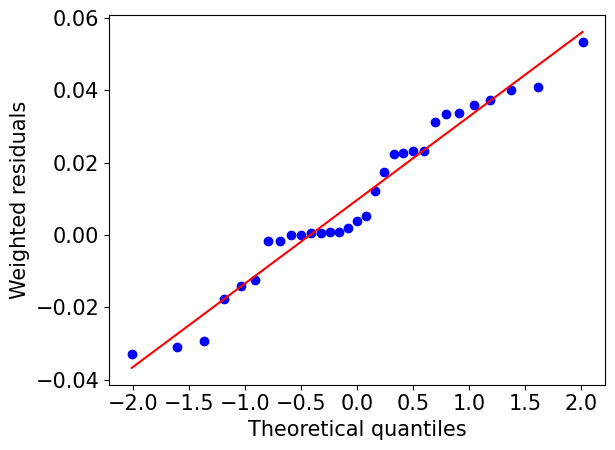

In [9]:
res.plot_normal_probability(show_fig = True, output_dir = None)

Comparison of the simulated and experimental measurements can be made by:

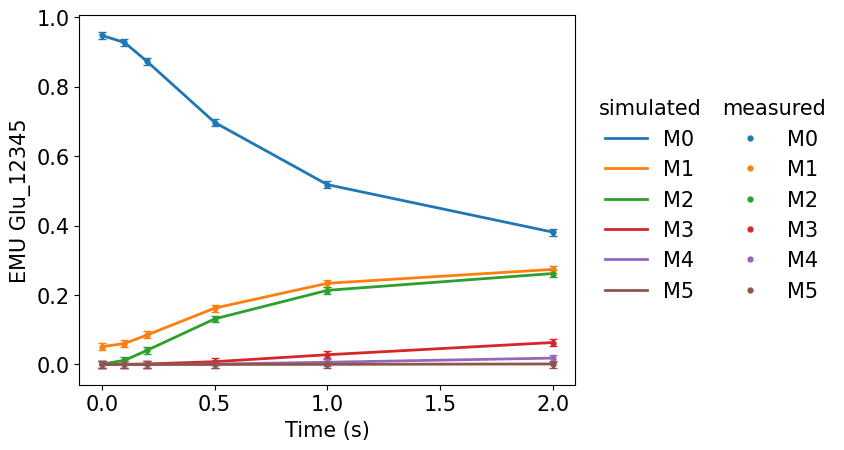

In [10]:
 res.plot_simulated_vs_measured_MDVs(show_fig = True, output_dir = None)

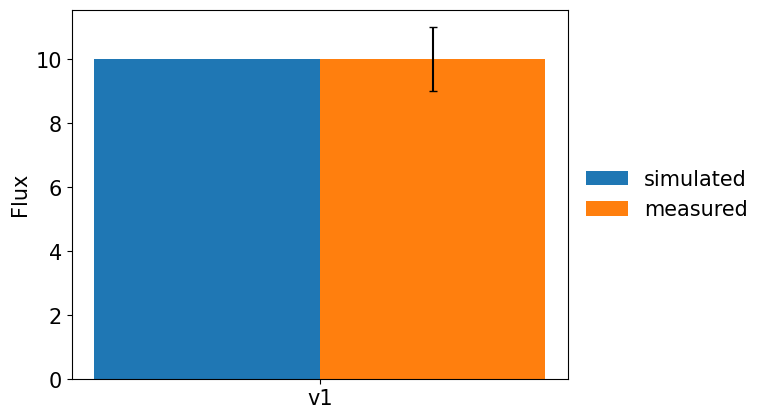

In [11]:
res.plot_simulated_vs_measured_fluxes(show_fig = True, output_dir = None)

Symmetric confidence intervals of fluxes at convergence can be obtained using the `estimate_confidence_intervals` method:

In [12]:
print(res.estimate_confidence_intervals(
    which = 'net',   # which = "total" for total fluxes
    confidence_level = 0.95
)) 

v1: [9.125, 10.876]
v2: [9.125, 10.876]
v3: [4.219, 5.725]
v4: [3.845, 6.213]
v5: [3.845, 6.213]
v6: [3.845, 6.213]
v7: [4.219, 5.725]


In [13]:
print(res.estimate_confidence_intervals(which = 'conc', confidence_level = 0.95))

AKG: [0.0, 3.603]
Cit: [3.013, 6.946]
Fum: [0.0, 1138.422]
Glu: [0.0, 2.857]
OAA: [0.0, 972.684]
Suc: [0.0, 181.646]


We can evaluate the contribution of measurement variances (including all timepoints) to the uncertainty of estimated fluxes by calculating the contribution matrix:

In [14]:
print(res.estimate_contribution_matrix(which = 'net')) # which = "total" for total fluxes

    Glu_12345_m0_0.1  Glu_12345_m1_0.1  Glu_12345_m2_0.1  Glu_12345_m3_0.1  \
v1          0.006657          0.001562          0.002262          0.000016   
v2          0.006657          0.001562          0.002262          0.000016   
v3          0.012128          0.002408          0.003313          0.000010   
v4          0.000094          0.000004          0.000002          0.000024   
v5          0.000094          0.000004          0.000002          0.000024   
v6          0.000094          0.000004          0.000002          0.000024   
v7          0.012128          0.002408          0.003313          0.000010   

    Glu_12345_m4_0.1  Glu_12345_m5_0.1  Glu_12345_m0_0.2  Glu_12345_m1_0.2  \
v1      2.239544e-06      3.003782e-10          0.049795          0.015252   
v2      2.239544e-06      3.003782e-10          0.049795          0.015252   
v3      1.395488e-07      1.694144e-11          0.084663          0.015899   
v4      1.805789e-06      2.380560e-10          0.000403       

The sensitivities of estimated fluxes with respect to measurement perturbations (including all timepoints) can be obtained by:

In [15]:
print(res.estimate_sensitivity(which = 'net')) # which = "total" for total fluxes

    Glu_12345_m0_0.1  Glu_12345_m1_0.1  Glu_12345_m2_0.1  Glu_12345_m3_0.1  \
v1         -3.369194          1.632079          1.963988         -0.164362   
v2         -3.369194          1.632079          1.963988         -0.164362   
v3         -3.912126          1.743226          2.044739          0.110744   
v4          0.542932         -0.111147         -0.080751         -0.275106   
v5          0.542932         -0.111147         -0.080751         -0.275106   
v6          0.542932         -0.111147         -0.080751         -0.275106   
v7         -3.912126          1.743226          2.044739          0.110744   

    Glu_12345_m4_0.1  Glu_12345_m5_0.1  Glu_12345_m0_0.2  Glu_12345_m1_0.2  \
v1         -0.061796         -0.000716         -9.214526          5.099624   
v2         -0.061796         -0.000716         -9.214526          5.099624   
v3          0.013270          0.000146        -10.336268          4.479272   
v4         -0.075066         -0.000862          1.121742       

Similarly, the `with` statement can also be used to perform flux estimation:

```
with model.fitter('inst') as ifit:
    ifit.set_labeling_strategy(
        'AcCoA', 
        labeling_pattern = ['01', '11'], 
        percentage = [0.25, 0.25], 
        purity = [1,1]
    )
    ifit.set_measured_MDVs_from_file(MEASURED_MDVS)
    ifit.set_measured_fluxes_from_file(MEASURED_FLUXES)
    ifit.set_flux_bounds(
        'all', 
        bounds = [-100, 100]
    )
    ifit.set_concentration_bounds(
        'all', 
        bounds = [0.001, 10]
    )
    ifit.prepare(n_jobs = 3)
    res = ifit.solve(solver = 'ralg')
```

A more complex example of flux estimation at INST state using an *Synechocystis* model is provided in the script "[tutorial_synechocystis_inst_estimation.py](https://github.com/Chaowu88/freeflux/tree/main/tutorials)"

## Dilution Parameter

Transient labeling of metabolites can be impeded by dilution effect. To account for it, we can add several special reactions to the network:

v1: 0A(abc) $\rightarrow$ As(abc)\
v2: 0Au(abc) $\rightarrow$ As(abc)\
v3: As(abc) $\rightarrow$ sink

where A is the metabolite involved in metabolic reactions, Au is the metabolically inactive (unlabeled) fraction, and As is the pseudo-metabolite denoting the metabolites measured in samples. The zero coefficient in v1 and v2 guarantees that the additional metabolites will have no effect on the mass balance of network reactions. The flux values of the reactions could be arbitrary, but the ratio v2/(v1+v2) is determined by the labeling patterns of A, Au, and As, which is estimated as the dilution parameter.

Then, we need to tell the decomposer the unlabeled dilution source(s), i.e., "Au" in the above example by setting the argument "dilution_from = 'Au'" in the `prepare` method.

## Solving the Fluxes with Confidence Intervals

Uncertainties of fluxes and concentrations can be estimated using the Monte Carlo method. The following code demonstrates how to do this:

In [16]:
model = Model('demo')
model.read_from_file(MODEL_FILE)

with model.fitter('inst') as ifit:
    ifit.set_labeling_strategy(
        'AcCoA', 
        labeling_pattern = ['01', '11'], 
        percentage = [0.25, 0.25], 
        purity = [1,1]
    )
    ifit.set_measured_MDVs_from_file(MEASURED_MDV_FILE)
    ifit.set_measured_fluxes_from_file(MEASURED_FLUX_FILE)
    ifit.set_flux_bounds(
        'all', 
        bounds = [-100, 100]
    )
    ifit.set_concentration_bounds(
        'all', 
        bounds = [0.001, 10]
    )
    ifit.prepare(n_jobs = 30)
    res = ifit.solve_with_confidence_intervals(
        n_runs = 30, 
        n_jobs = 3
    )


INST fitting with CIs [elapsed: 0:07:49]



<div class="alert alert-info">

<b>Note:</b> <br></br> For the estimation of CIs for large-sized models, we strongly recommend running with parallel jobs. One can achieve this by setting the 'n_jobs' argument of the `solve_with_confidence_intervals` method to a value greater than 1.

</div>

In [17]:
print(res.estimate_confidence_intervals(
    which = 'net',   # which = "total" for total fluxes
    confidence_level = 0.95
)) 

v1: [8.078, 10.78]
v2: [8.078, 10.78]
v3: [2.102, 5.724]
v4: [3.605, 8.557]
v5: [3.605, 8.557]
v6: [3.605, 8.557]
v7: [2.102, 5.724]


In [18]:
print(res.estimate_confidence_intervals(which = 'conc', confidence_level = 0.95))

AKG: [0.0, 1.277]
Cit: [0.001, 5.554]
Fum: [0.0, 1.23]
Glu: [0.0, 3.375]
OAA: [0.001, 2.916]
Suc: [0.0, 2.489]


For a more complex example of flux estimation with CIs of a *Synechocystis* model, please refer to the script "[tutorial_synechocystis_inst_estimation.py](https://github.com/Chaowu88/freeflux/tree/main/tutorials)"